<a href="https://colab.research.google.com/github/tommybebe/til/blob/master/ml/keras_add_layer_after_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### References
- [Unsupervised Visual Representation Learning Overview： Toward Self-Supervision](https://hoya012.github.io/blog/Self-Supervised-Learning-Overview/)
- [Keras Fashion MNIST](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb#scrollTo=SaYPv_aKId2d)

### Setup

In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

4423680/4422102 [==============================] - 0s 0us/step


### create initial model

In [21]:
input_shape = x_train.shape[1:]

def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Activation('softmax'))
    return model

In [22]:
with tf.device('/device:GPU:0'):
    model = create_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

In [23]:
model.fit(
    x_train, 
    y_train,
    epochs=15,
    steps_per_epoch=60,
    validation_data=(x_test, y_test),
    validation_freq=15
)

Epoch 1/15
60/60 [==============================] - 2s 26ms/step - loss: 0.6204 - sparse_categorical_accuracy: 0.7879
Epoch 2/15
60/60 [==============================] - 2s 26ms/step - loss: 0.4009 - sparse_categorical_accuracy: 0.8620
Epoch 3/15
60/60 [==============================] - 2s 26ms/step - loss: 0.3579 - sparse_categorical_accuracy: 0.8753
Epoch 4/15
60/60 [==============================] - 2s 26ms/step - loss: 0.3291 - sparse_categorical_accuracy: 0.8862
Epoch 5/15
60/60 [==============================] - 2s 26ms/step - loss: 0.3083 - sparse_categorical_accuracy: 0.8921
Epoch 6/15
60/60 [==============================] - 2s 26ms/step - loss: 0.2937 - sparse_categorical_accuracy: 0.8970
Epoch 7/15
60/60 [==============================] - 2s 26ms/step - loss: 0.2811 - sparse_categorical_accuracy: 0.9022
Epoch 8/15
60/60 [==============================] - 2s 26ms/step - loss: 0.2698 - sparse_categorical_accuracy: 0.9058
Epoch 9/15
60/60 [==============================] - 2s 2

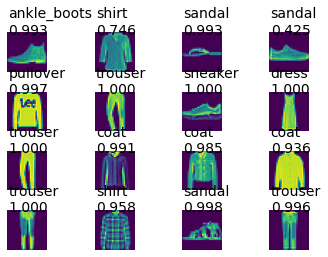

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  
  f, axes = plt.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

plot_predictions(np.squeeze(x_test[:16]), model.predict(x_test[:16]))
plt.subplots_adjust(hspace=0.5)

### add more layers
- [recreate model without last layer](https://stackoverflow.com/a/59304656)
    ```
model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    model.add(layer)
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')
    ```

- layer freeze

    > 그래서 unsupervised pretraining의 효과를 확인하기 위해 논문 들에서는 Self-Supervised Learning으로 Network를 pretraining 시킨 뒤 모든 weight들을 freeze 시킵니다. Pretraining을 통해 얻은 weight들이 얼마나 feature를 잘 뽑는지, representation을 얼마나 잘 배웠는지 에 초점을 두기 때문입니다.



In [54]:
# ..
# ...
# model.layers[:-3] : model.add(tf.keras.layers.Flatten())
# model.layers[:-2] : model.add(tf.keras.layers.Dense(10))
# model.layers[:-1] : model.add(tf.keras.layers.Activation('softmax'))

with tf.device('/device:GPU:0'):
    m = tf.keras.models.Sequential()
    for layer in model.layers[:-2]:
        m.add(layer)
    
    for layer in m.layers:
        layer.trainable = False

    m.add(tf.keras.layers.Dense(1024,activation="relu"))
    m.add(tf.keras.layers.BatchNormalization())
    m.add(tf.keras.layers.Dropout(rate=0.4))
    m.add(tf.keras.layers.Dense(10))
    m.add(tf.keras.layers.Activation('softmax'))

    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

In [55]:
m.fit(
    x_train, 
    y_train,
    epochs=15,
    steps_per_epoch=60,
    validation_data=(x_test, y_test),
    validation_freq=15
)

Epoch 1/15
60/60 [==============================] - 1s 25ms/step - loss: 0.5340 - sparse_categorical_accuracy: 0.8406
Epoch 2/15
60/60 [==============================] - 1s 24ms/step - loss: 0.2915 - sparse_categorical_accuracy: 0.8954
Epoch 3/15
60/60 [==============================] - 1s 24ms/step - loss: 0.2420 - sparse_categorical_accuracy: 0.9121
Epoch 4/15
60/60 [==============================] - 1s 24ms/step - loss: 0.2072 - sparse_categorical_accuracy: 0.9244
Epoch 5/15
60/60 [==============================] - 1s 24ms/step - loss: 0.1816 - sparse_categorical_accuracy: 0.9332
Epoch 6/15
60/60 [==============================] - 1s 24ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.9390
Epoch 7/15
60/60 [==============================] - 1s 24ms/step - loss: 0.1504 - sparse_categorical_accuracy: 0.9444
Epoch 8/15
60/60 [==============================] - 1s 24ms/step - loss: 0.1378 - sparse_categorical_accuracy: 0.9490
Epoch 9/15
60/60 [==============================] - 1s 2